In [2]:
pip install requests pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime

# --- Helper: Convert date to UNIX timestamp ---
def get_unix_timestamp(date_str):
    return int(datetime.strptime(date_str, "%Y-%m-%d").timestamp())

# --- Parameters ---
API_KEY = '404a6aea07fb8700da00a46a866d3813f7444289f56ce6902f6e8ca4e04be78c'
START_DATE = "2013-01-01"
END_DATE = "2015-01-01"
LIMIT_DAYS = 730  # Approx. 2 years

url = "https://min-api.cryptocompare.com/data/v2/histoday"
params = {
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': LIMIT_DAYS,
    'toTs': get_unix_timestamp(END_DATE),
    'api_key': API_KEY
}

# --- Fetch data ---
response = requests.get(url, params=params)
data = response.json()

# --- Create DataFrame ---
df = pd.DataFrame(data['Data']['Data'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Filter for proper date range
df = df[df['time'] >= START_DATE].reset_index(drop=True)

# Define xt (volume) and yt (closing price)
df['xt'] = df['volumeto']
df['yt'] = df['close']

# Final DataFrame
df = df[['time', 'xt', 'yt']].dropna().reset_index(drop=True)

# --- Preview ---
print(f"Data points: {len(df)}")
print(df.head())


Data points: 731
        time         xt     yt
0 2013-01-01  378879.35  13.30
1 2013-01-02  239156.18  13.28
2 2013-01-03  240845.86  13.40
3 2013-01-04  397884.35  13.50
4 2013-01-05  286932.51  13.44


In [4]:
# --- STEP 2: OLS Estimation (Analytical) with Scaling ---

# Standardize xt and yt
xt_scaled = (df['xt'] - df['xt'].mean()) / df['xt'].std()
yt_scaled = (df['yt'] - df['yt'].mean()) / df['yt'].std()

# Prepare design matrix
X = np.vstack([np.ones_like(xt_scaled), xt_scaled]).T
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ yt_scaled

# Extract coefficients
alpha_ols, beta_ols_value = beta_ols

print("STEP 2: OLS Estimation (with standardized data)")
print(f"Alpha (intercept): {alpha_ols:.4f}")
print(f"Beta (slope): {beta_ols_value:.4f}")


STEP 2: OLS Estimation (with standardized data)
Alpha (intercept): 0.0000
Beta (slope): 0.2919


In [5]:
# --- STEP 3: Trial-and-Error (Grid Search) ---

# Define search ranges around the OLS estimates
alpha_range = np.linspace(-1, 1, 100)  # Search around 0 (mean-centered)
beta_range = np.linspace(0, 1, 100)    # Try a wide range for slope

best_loss = float('inf')
best_alpha = None
best_beta = None

# Grid search for (alpha, beta) pair with lowest MSE
for a in alpha_range:
    for b in beta_range:
        y_pred = a + b * xt_scaled
        mse = np.mean((yt_scaled - y_pred) ** 2)
        if mse < best_loss:
            best_loss = mse
            best_alpha = a
            best_beta = b

# Report results
print("STEP 3: Trial-and-Error Estimation")
print(f"Best Alpha: {best_alpha:.4f}")
print(f"Best Beta: {best_beta:.4f}")
print(f"Minimum MSE: {best_loss:.4f}")


STEP 3: Trial-and-Error Estimation
Best Alpha: 0.0101
Best Beta: 0.2929
Minimum MSE: 0.9137


STEP 4: Gradient Descent Estimation
Alpha: 0.0000
Beta: 0.2919
Final MSE: 0.9136


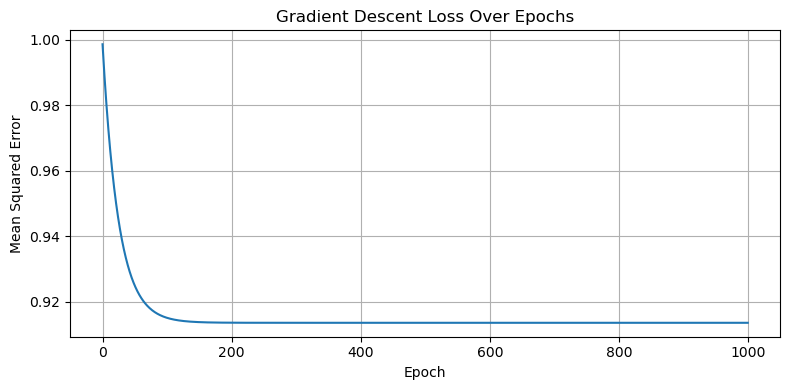

In [6]:
import matplotlib.pyplot as plt

# --- STEP 4: Gradient Descent ---

# Initialize parameters
alpha_gd = 0.0
beta_gd = 0.0
learning_rate = 0.01
epochs = 1000

losses = []

for epoch in range(epochs):
    y_pred = alpha_gd + beta_gd * xt_scaled
    error = y_pred - yt_scaled
    
    # Compute gradients
    grad_alpha = 2 * np.mean(error)
    grad_beta = 2 * np.mean(error * xt_scaled)
    
    # Update parameters
    alpha_gd -= learning_rate * grad_alpha
    beta_gd -= learning_rate * grad_beta
    
    # Record loss
    mse = np.mean(error ** 2)
    losses.append(mse)

# --- Output ---
print("STEP 4: Gradient Descent Estimation")
print(f"Alpha: {alpha_gd:.4f}")
print(f"Beta: {beta_gd:.4f}")
print(f"Final MSE: {losses[-1]:.4f}")

# --- Plot Loss Over Epochs ---
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Gradient Descent Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.tight_layout()
plt.show()


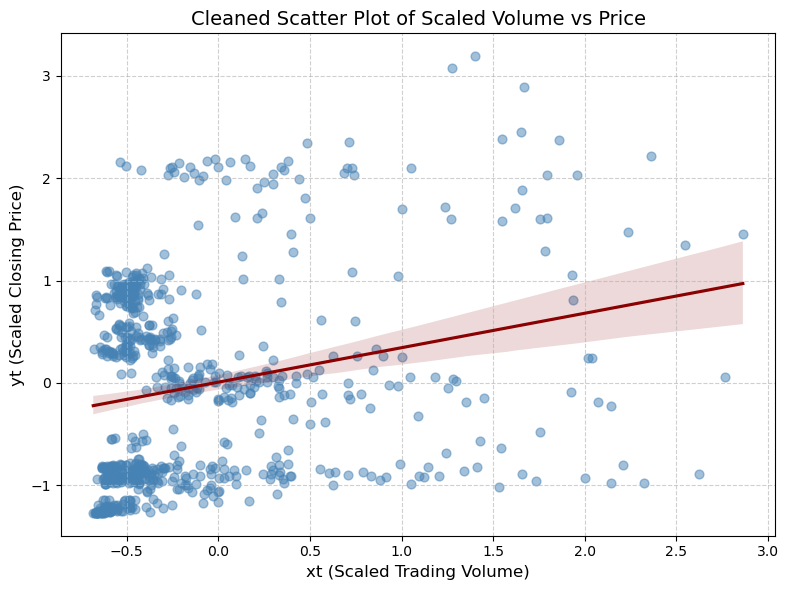

In [8]:

import seaborn as sns

xt_filtered = xt_scaled[np.abs(xt_scaled) < 3]
yt_filtered = yt_scaled[np.abs(xt_scaled) < 3]  

plt.figure(figsize=(8, 6))
sns.regplot(x=xt_filtered, y=yt_filtered, scatter_kws={'alpha': 0.5, 's': 40, 'color': 'steelblue'}, line_kws={"color": "darkred"})
plt.title("Cleaned Scatter Plot of Scaled Volume vs Price", fontsize=14)
plt.xlabel("xt (Scaled Trading Volume)", fontsize=12)
plt.ylabel("yt (Scaled Closing Price)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



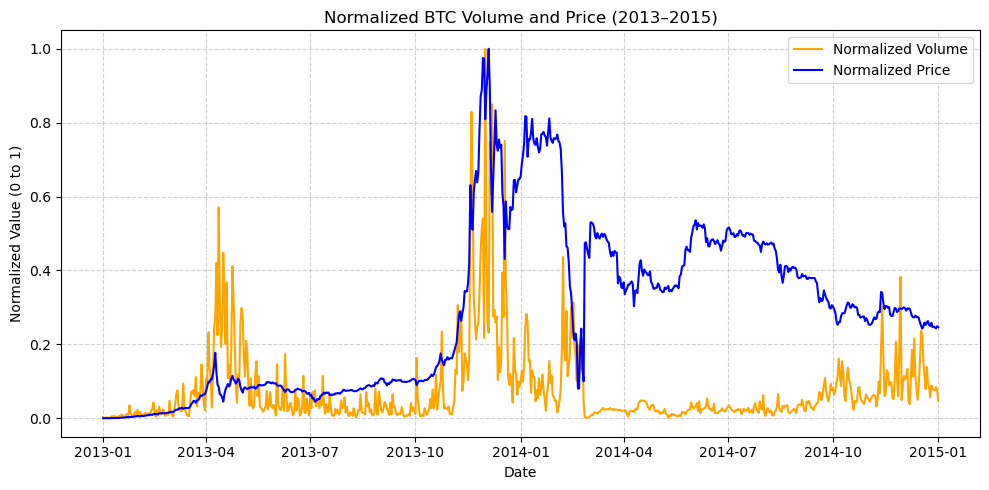

In [10]:
# Normalize both series to [0, 1]
xt_norm = (df['xt'] - df['xt'].min()) / (df['xt'].max() - df['xt'].min())
yt_norm = (df['yt'] - df['yt'].min()) / (df['yt'].max() - df['yt'].min())

# Plot normalized comparison
plt.figure(figsize=(10, 5))
plt.plot(df['time'], xt_norm, label='Normalized Volume', color='orange')
plt.plot(df['time'], yt_norm, label='Normalized Price', color='blue')
plt.title("Normalized BTC Volume and Price (2013–2015)")
plt.xlabel("Date")
plt.ylabel("Normalized Value (0 to 1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Discussion:

In practice, gradient descent can fail to converge for a variety of reasons:

The learning rate may be set excessively high, leading the algorithm to exceed the minimum and diverge.

If the input characteristics are not scaled, especially when dealing with variables of various magnitudes like trading volume and price, the optimisation may become unstable or slow.

High variance or outliers in the data may distort the gradient, making convergence more difficult.

How To Improve Convergence

Standardise or normalise the input data so that the mean is zero and the variance is one.

Choose a lower learning rate and increase the number of repetitions.

Use adaptive optimisers like Adam or RMSprop (common in machine learning systems).

Continuously monitor the loss curve to ensure that convergence happens as expected.